# About this competition from Kaggle

In this dataset, you are provided with game analytics for the PBS KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.

The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt). Each application install is represented by an installation_id. This will typically correspond to one child, but you should expect noise from issues such as shared devices. In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

3: the assessment was solved on the first attempt
2: the assessment was solved on the second attempt
1: the assessment was solved after 3 or more attempts
0: the assessment was never solved

The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

### Inspiration / References for this piece:

Erik Bruin's extensive EDA and baseline kernel [https://www.kaggle.com/erikbruin/data-science-bowl-2019-eda-and-baseline](http://) 

Gabriel Preda's detailed data exploration plots https://www.kaggle.com/gpreda/2019-data-science-bowl-eda#Data-exploration

Guillaume Martin's memory reduction function in this kernel - https://www.kaggle.com/gemartin/load-data-reduce-memory-usage. 

We start by importing the necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold


# Data input

Reading all the data files

In [2]:
%%time
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

CPU times: user 1min 12s, sys: 8.92 s, total: 1min 21s
Wall time: 1min 21s


In [3]:
np.random.seed(123)

Important to note that the files have taken 1 min 20s to be read. As Kaggle points out this is a synchronous rerun code competition and the private test set has approximately 8MM rows. We should be mindful of memory in your notebooks to avoid submission errors.

# Data Formatting

In [4]:
train.sample(10)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
5636270,a0faea5d,05df65df7c0b242d,2019-10-12T14:51:50.069Z,"{""coordinates"":{""x"":442,""y"":455,""stage_width"":...",7cea4e3e,53,4070,127000,Bubble Bath,Game,MAGMAPEAK
4693790,1325467d,b761f354302597b9,2019-08-16T05:43:38.201Z,"{""coordinates"":{""x"":846,""y"":198,""stage_width"":...",69070a06,166,4070,128163,Sandcastle Builder (Activity),Activity,MAGMAPEAK
9401646,499edb7c,b4c71262292cb86b,2019-08-01T00:34:46.224Z,"{""side"":""right"",""layout"":{""left"":{""chickens"":0...",d25338cb,10,4020,12469,Chicken Balancer (Activity),Activity,CRYSTALCAVES
7828316,c1cac9a2,3fb455470932241c,2019-07-26T20:38:01.637Z,"{""movie_id"":""scrubadub_outro"",""duration"":13900...",af6786f7,234,2081,227437,Scrub-A-Dub,Game,MAGMAPEAK
100871,71fe8f75,01ad4b9194ada027,2019-09-09T20:32:04.828Z,"{""description"":""Two!"",""identifier"":""sid_2"",""me...",0235fe9a,147,3110,63594,Bug Measurer (Activity),Activity,TREETOPCITY
3025541,5c3d2b2f,0b7b28bf0326f266,2019-08-05T21:47:29.957Z,"{""size"":4,""item_type"":""Soap"",""position"":4,""ani...",42f49cdb,520,4020,463289,Scrub-A-Dub,Game,MAGMAPEAK
6358496,7372e1a5,124e67270b8d90b8,2019-10-12T01:25:41.736Z,"{""coordinates"":{""x"":115,""y"":522,""stage_width"":...",8cd1cf19,179,4070,148333,Chow Time,Game,CRYSTALCAVES
9100968,5e3ea25a,7f93781d3694d947,2019-09-06T19:23:01.569Z,"{""coordinates"":{""x"":953,""y"":163,""stage_width"":...",cce6a641,33,4070,28947,Crystals Rule,Game,TREETOPCITY
10337663,0a08139c,cb7260e1bb6ae30b,2019-10-03T23:02:02.680Z,"{""description"":""Three!"",""identifier"":""sid_3"",""...",ea49ea9c,58,3010,32423,Bug Measurer (Activity),Activity,TREETOPCITY
3241247,67439901,72aad16ace455e9c,2019-10-14T14:16:52.805Z,"{""description"":""Oh, wow!"",""identifier"":""ohWow""...",47f2f126,94,3010,144029,Bottle Filler (Activity),Activity,MAGMAPEAK


In [5]:
train.shape

(11341042, 11)

So we have 11 features and 11 million rows in the train data 
From Kaggle, these are the main data files which contain the gameplay events.

* event_id - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
* game_session - Randomly generated unique identifier grouping events within a single game or video play session.
* timestamp - Client-generated datetime
* event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.
* installation_id - Randomly generated unique identifier grouping game sessions within a single installed application instance.
* event_count - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
* event_code - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
* game_time - Time in milliseconds since the start of the game session. Extracted from event_data.
* title - Title of the game or video.
* type - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
* world - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [6]:
test.sample(10)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
100023,262136f4,5a9cb5660c141a07,2019-09-30T19:19:54.371Z,"{""dinosaur"":""ned"",""dinosaur_weight"":4,""correct...",15f9b137,22,4020,62430,Leaf Leader,Game,CRYSTALCAVES
397924,363d3849,ab6b615a35515e0d,2019-09-08T17:25:26.332Z,"{""media_type"":""animation"",""total_duration"":400...",5a6f3de8,18,3010,22403,All Star Sorting,Game,TREETOPCITY
7333,58a0de5c,cfd960bfc35c271e,2019-09-05T15:04:10.430Z,"{""description"":""You did it!"",""identifier"":""You...",027e7ce5,30,3121,62282,Air Show,Game,TREETOPCITY
29802,cf82af56,40692bea4a5a824e,2019-08-31T21:52:20.828Z,"{""coordinates"":{""x"":750,""y"":821,""stage_width"":...",090fe325,252,4070,267668,Scrub-A-Dub,Game,MAGMAPEAK
208097,28f975ea,ab2ded207cc4a51c,2019-08-13T20:12:06.142Z,"{""distance"":6,""dinosaur"":""tiny"",""target_distan...",2e6923d6,51,4020,58826,Air Show,Game,TREETOPCITY
1101813,02a42007,f89aac4cb5903fec,2019-09-26T15:26:39.417Z,"{""rocket"":5,""coordinates"":{""x"":525,""y"":656,""st...",f4ecc4cc,22,4030,33878,Fireworks (Activity),Activity,TREETOPCITY
368767,47026d5f,c41b62d2cf4de2a6,2019-08-12T15:53:16.697Z,"{""description"":""Good job, that was just right!...",56a739ec,38,3021,74902,Chow Time,Game,CRYSTALCAVES
509956,e9c52111,1fd3306386a4501b,2019-08-18T01:07:22.970Z,"{""jar"":[{""color"":""blue"",""amount"":1},{""color"":""...",781b4d97,112,2030,123081,Bottle Filler (Activity),Activity,MAGMAPEAK
973420,56bcd38d,3f625e93fe8531c9,2019-10-07T21:42:11.721Z,"{""object"":""chicken"",""layout"":{""left"":{""chicken...",d4cc2b9f,84,4030,66584,Chicken Balancer (Activity),Activity,CRYSTALCAVES
916834,de26c3a6,77ad5aca5eb4ae6f,2019-08-23T20:30:44.586Z,"{""growth"":[1,0,0,0,0],""flowers"":[8,8,8,8,8],""d...",cd00d04e,18,4020,50279,Flower Waterer (Activity),Activity,TREETOPCITY


In [7]:
test.shape

(1156414, 11)

The test data also contains around 11 million rows and the same 11 features

As Kaggle mentioned that only assessments are used in the testing criteria, it makes no sense to retain installation ids that do not contain an assessment

In [8]:
assessed_only = train[train.type == 'Assessment'].drop_duplicates(subset='installation_id')[['installation_id']]
train = train[train.installation_id.isin(assessed_only['installation_id'])]
train.shape

(8294138, 11)

This has reduced the train data to 8 million rows. 

To understand how the data comes together, we will see if there are any common installation ids in the test and train 

In [9]:
len(set(train.installation_id.unique()) & (set(test.installation_id.unique())))

0

Ok that's good this means kids (or kids sharing devices with the same installation_id) that are in the train are not present in the test. 
What about game session? Are there any common values in train and test?

In [10]:
len(set(train.game_session.unique()) & (set(test.game_session.unique())))

0

None, again. How about event_ids?

In [11]:
len(set(train.event_id.unique()) & (set(test.event_id.unique())))

365

We understand that event_ids are randomly generated identifiers for event type. To understand what events are we can look into the specs data from which the identifier maps the event related info

In [12]:
pd.options.display.max_colwidth = 150
specs.sample(10)

,event_id,info,args
231,e080a381,This event occurs when the player clicks on the character that provides a hint (Sorry I don't know his name). It contains information about the st...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
105,86ba578b,The beat round event is triggered when the player finishes the tutorial. This event is used for calculating time spent in the tutorial.,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
66,0d1da71f,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that de...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
119,bdf49a58,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that de...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""description"",""type"":""string"",""info"":""the text or descri..."
22,99abe2bb,The movie started event triggers when an intro or outro movie starts to play. It identifies the movie being played. This is used to determine how ...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
63,0db6d71d,"This event occurs when the player places a chest on one of the three pillars. It contains information about the chest that was placed, the correct...","[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""weight"",""type"":""int"",""info"":""weight of the chest that w..."
137,7ad3efc6,"The start game event is triggered at the very beginning of the level (after the game finishes loading, don't wait for intro movie to finish). This...","[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""version"",""type"":""string"",""info"":""identifier of the curr..."
348,67aa2ada,This event occurs when the player clicks on the help button. It contains information about the state of the game that caused the player to seek he...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
337,3bf1cf26,The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
224,6077cc36,"This event occurs when the player hovers the mouse over an interactive object. It contains information about the object under the mouse, and the d...","[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""dwell_time"",""type"":""int"",""info"":""how long the mouse cur..."


Ok, so these are all events triggered within the app. Some examples include:
* When the player hovers mouse over an interactive object
* When the player clicks on the help button
* When the player picks a mushroom in the resource area

Therefore it makes sense that there are 365 events that are common to both train and test. Further more, Kaggle also defines the variable in the specs.csv

* event_id - Global unique identifier for the event type. Joins to event_id column in events table.
* info - Description of the event.
* args - JSON formatted string of event arguments. Each argument contains:
* name - Argument name.
* type - Type of the argument (string, int, number, object, array).
* info - Description of the argument.

Before getting into the data analysis part, we need to beware of memory usage.
I found a memory reduction function in this kernel - https://www.kaggle.com/gemartin/load-data-reduce-memory-usage. All credits go to Guillaume Martin.

In [13]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [14]:
reduce_mem_usage(train)

Memory usage of dataframe is 759.35 MB
Memory usage after optimization is: 632.79 MB
Decreased by 16.7%


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1539,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""id...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
1542,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":1015,""stage_height"":762},""event_count"":3,""game_time"":2137,""event_code"":4070}",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
...,...,...,...,...,...,...,...,...,...,...,...
11337821,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""selecting"",""round_number"":2,""duration"":7067,""event_count"":58,""game_time"":67094,""event_code"":2030}",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337822,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_bucket"":1,""coordinates"":{""x"":552,""y"":401,""stage_width"":1015,""stage_height"":762},""correct"":true,""promp...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337823,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Awesome"",""media_type"":""audio"",""total_duration"":700,""event_count"":59,""game_time"":67094,""event_code"":3021}",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
11337824,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Awesome"",""media_type"":""audio"",""duration"":753,""event_count"":60,""game_time"":67847,""event_code"":3121}",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [15]:
reduce_mem_usage(test)

Memory usage of dataframe is 97.05 MB
Memory usage after optimization is: 79.40 MB
Decreased by 18.2%


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""game_time"":0,""event_code"":2000}",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES
...,...,...,...,...,...,...,...,...,...,...,...
1156409,c74f40cd,46ff9d3ad2be09f2,2019-09-28T21:20:40.918Z,"{""description"":""Alright! This one is the littlest mushroom, and this one is the biggest!"",""identifier"":""Dot_AlrightThisLittleThisBig"",""media_type""...",ffe774cc,39,3121,32030,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156410,6c930e6e,46ff9d3ad2be09f2,2019-09-28T21:20:41.493Z,"{""duration"":20008,""misses"":0,""event_count"":40,""game_time"":32584,""event_code"":2030}",ffe774cc,40,2030,32584,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156411,a5be6304,46ff9d3ad2be09f2,2019-09-28T21:20:45.499Z,"{""session_duration"":36607,""exit_type"":""game_completed"",""event_count"":41,""game_time"":36607,""event_code"":2010}",ffe774cc,41,2010,36607,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156412,27253bdc,96d7dc31e822cedc,2019-09-28T21:21:05.670Z,"{""event_code"": 2000, ""event_count"": 1}",ffe774cc,1,2000,0,Tree Top City - Level 3,Clip,TREETOPCITY


In [16]:
reduce_mem_usage(specs)

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 0.0%


,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct roun...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
1,df4fe8b6,The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""description"",""type"":""string"",""info"":""the text or descri..."
2,3babcb9b,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that de...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
3,7f0836bf,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that de...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
4,ab3136ba,The end of system-initiated instruction event occurs when the game finishes delivering instructions to the player. It contains information that de...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
...,...,...,...
381,29f54413,The start round event is triggered at the start of the tutorial. It is used in calculating time spent in the tutorial.,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
382,06372577,The start tutorial event is triggered at the start of the tutorial. It is used in calculating time spent in the tutorial.,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
383,2a444e03,This event occurs when the player picks up a weight from the table. It contains information about the weight being picked. This event is used to d...,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."
384,9e6b7fb5,This event occurs when the player clicks on the play again button.,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round..."


In [17]:
reduce_mem_usage(train_labels)

Memory usage of dataframe is 0.94 MB
Memory usage after optimization is: 0.49 MB
Decreased by 48.2%


,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3
...,...,...,...,...,...,...,...
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333252,1
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0


# Data Exploration 

Plotting event code by row counts

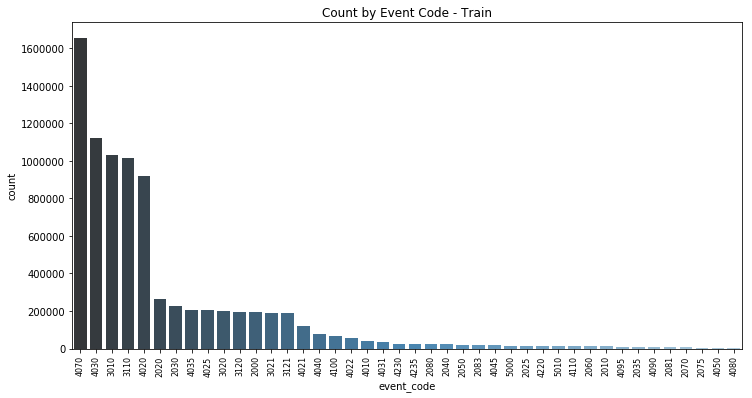

In [18]:
plt.figure(figsize=(12,6))


sns.countplot(x='event_code',data=train, palette = 'Blues_d',
              order = train['event_code'].value_counts().index).set_title('Count by Event Code - Train')
plt.xticks(rotation=90,fontsize=8)
plt.show()

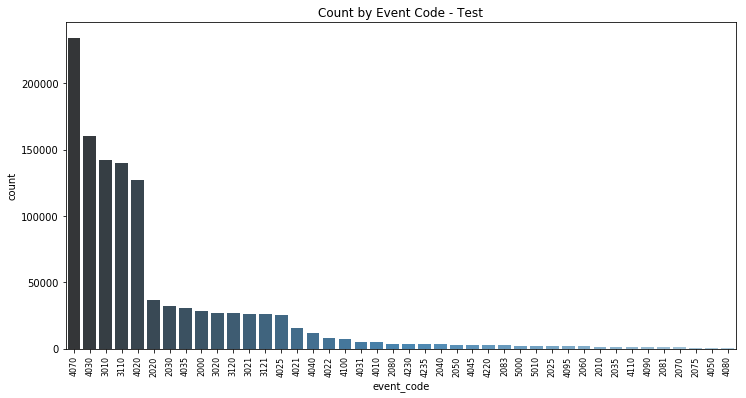

In [19]:
plt.figure(figsize=(12,6))


sns.countplot(x='event_code',data=test, palette = 'Blues_d',
              order = test['event_code'].value_counts().index).set_title('Count by Event Code - Test')
plt.xticks(rotation=90,fontsize=8)
plt.show()

The event code is heavily skewed. This will cause us problems when making them dummy variables. We will deal with them later.

We also notice another field event_count, can we find out which event code has the highest event counts?

In [20]:
train.groupby('event_code')[['event_count']].agg('sum').sort_values(by = 'event_count',ascending=False).head(10)

,event_count
event_code,
4070,181312603.0
4030,105499023.0
4020,95968578.0
3110,95080480.0
3010,94346553.0
2030,29159035.0
2020,27895496.0
3120,25132986.0
3020,24839704.0


Event 4070 seems to have the highest event count. What about the test data?

In [21]:
test.groupby('event_code')[['event_count']].agg('sum').sort_values(by = 'event_count',ascending=False).head(10)

,event_count
event_code,
4070,39616099.0
4030,15478399.0
3110,13147721.0
3010,13053906.0
4020,13049406.0
2030,3969022.0
2020,3801238.0
4035,3606190.0
3120,3472804.0


Ok that's more or less similar. Let's now look at the train labels data

In [22]:
train_labels.sample(10)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
1994,9ee9db28e2885791,1a5ec009,Cart Balancer (Assessment),1,0,1.000000,3
10989,1ab4a9e4670f2259,9a31bcac,Chest Sorter (Assessment),0,2,0.000000,0
2214,9d39c894a28fd63e,1bfc9ff2,Bird Measurer (Assessment),1,8,0.111084,1
6669,c406390a7ec541c9,57c583d8,Cart Balancer (Assessment),1,0,1.000000,3
17077,66fbb8cb77f9c9d7,f6f9f520,Bird Measurer (Assessment),0,1,0.000000,0
4412,82ac498cbba307e6,3a509a6a,Bird Measurer (Assessment),1,0,1.000000,3
5414,77b75b542c925a3d,48a48308,Cauldron Filler (Assessment),1,0,1.000000,3
14738,2e0fda322f6527f9,d28885da,Bird Measurer (Assessment),1,0,1.000000,3
17562,6a867119c9a0e030,fc70e779,Chest Sorter (Assessment),0,2,0.000000,0
524,76c45e045fe3ba63,063e3e02,Chest Sorter (Assessment),1,15,0.062500,1


So this data contains our target variable - the accuracy group.

Kaggle mentions that this file demonstrates how to compute the ground truth for the assessments in the training set.

We can also take out installation_ids that don't have the target variable in the train labels data. 

In [23]:
train = train[train.installation_id.isin(train_labels.installation_id.unique())]

So now the train data has reduced to 7 million rows

In [24]:
train.shape

(7734558, 11)

Are there any missing values in the data?

In [25]:
train.isnull().sum()

event_id           0
game_session       0
timestamp          0
event_data         0
installation_id    0
event_count        0
event_code         0
game_time          0
title              0
type               0
world              0
dtype: int64

In [26]:
test.isnull().sum()

event_id           0
game_session       0
timestamp          0
event_data         0
installation_id    0
event_count        0
event_code         0
game_time          0
title              0
type               0
world              0
dtype: int64

In [27]:
specs.isnull().sum()

event_id    0
info        0
args        0
dtype: int64

In [28]:
train_labels.isnull().sum()

game_session       0
installation_id    0
title              0
num_correct        0
num_incorrect      0
accuracy           0
accuracy_group     0
dtype: int64

There appears to be no missing values in the data. 

In order to understand the data better, we plot out some of the variables

Text(0.5, 1.0, 'Count by game type - Train')

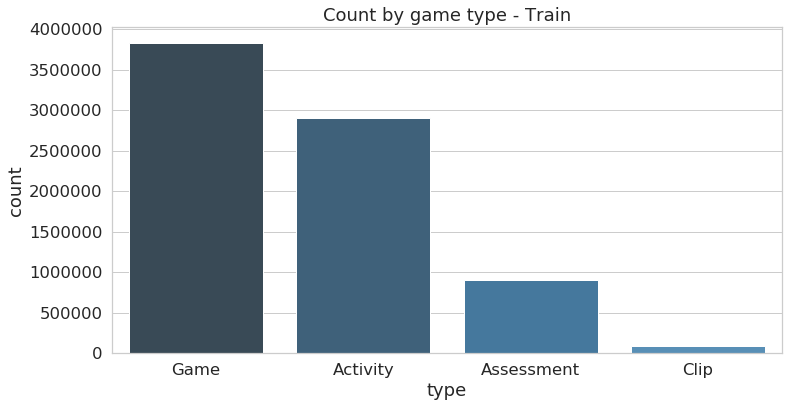

In [29]:
sns.set(font_scale=1.5,palette = 'Blues_d')
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))


sns.countplot(x='type',data=train,
              order = train['type'].value_counts().index).set_title('Count by game type - Train')

Text(0.5, 1.0, 'Count by game type - Test')

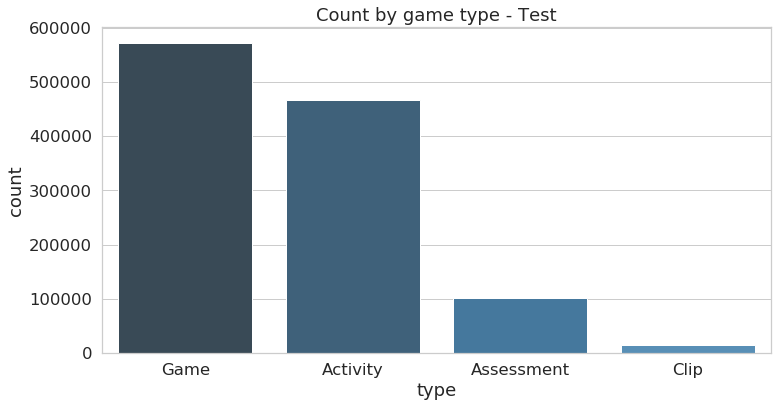

In [30]:
sns.set(font_scale=1.5,palette = 'Blues_d')
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))


sns.countplot(x='type',data=test,
              order = test['type'].value_counts().index).set_title('Count by game type - Test')

This thread (https://www.kaggle.com/c/data-science-bowl-2019/discussion/115034) contains some information about the different types of content. 

Each content type can be loosely thought of as corresponding to a phase of the learning cycle.

Clips
Videos are intended to expose the kid to a topic or a problem solving approach. Videos typically model or explain things. There is no interactive component to videos. Clips can further be classified into:
- Interstitials: short transitional videos between worlds or sections of the world, in which the protagonists of the adventure (Del, Dot and Dee) are seen exploring the island. Aside from the introductory video titled 'Welcome To The Lost Lagoon!', these can be identified by the title specifying the world and the relevant section (e.g. 'Crystal Caves - Level 1'). These videos merely hint to the subject matter.
- Longer clips (2-3 minutes in length): these videos explain an important subject or approach with the help of familiar characters from the PBS KIDS world. Typically these videos have been excerpted from longer television episodes.

Keep in mind in the dataset only the start of the video playback is captured. Therefore there are far fewer events corresponding to clips than there are to games or assessments. That does not mean clips are less popular! Also, lack of interactivity notwithstanding, there is good evidence that video contributes significantly to learning outcomes.

Activities
Activities are open-ended mini-games that allow kids to practice their skills in an environment that mimics real life play patterns to support “messing about”. Activities do not have a defined goal, but they do typically model cause and effect. We sometimes refer to Activities as 'sandboxes' or 'toys'.

Games
These are the typical video games most people are familiar with. Games help kids practice their skills with the goal of solving a specific problem. Each challenge may belong to a progressively more challenging round (marked in the data), and multiple rounds may be grouped into levels. Games do not end until the player finishes the game or decides to exit the play session. If a final goal is achieved, there is usually an option to replay the entire game from the start.

Assessments
Assessments are interactives that are designed specifically with the goal of measuring a player’s knowledge of the subject matter. Metrics that represent the intrinsic knowledge of the user are typically derived either from first principles rooted in childhood educational psychometry or from a posteriori data observations. One such (simple) metric might be the number of incorrect answers leading to the assessment solution, but many others can be formulated.

There are some interesting points to note here:

* The reason why our plot has far fewer clips count than other contents is becuse there are less events for videos as the dataset only captures the start of a video
* Since games help kids practice their skills, we may be able to say that kids who frequently replay / easily progress through games have a higher chance of getting a correct answer in the assessment at the first attempt

So what about worlds?

Text(0.5, 1.0, 'Count by World - Train')

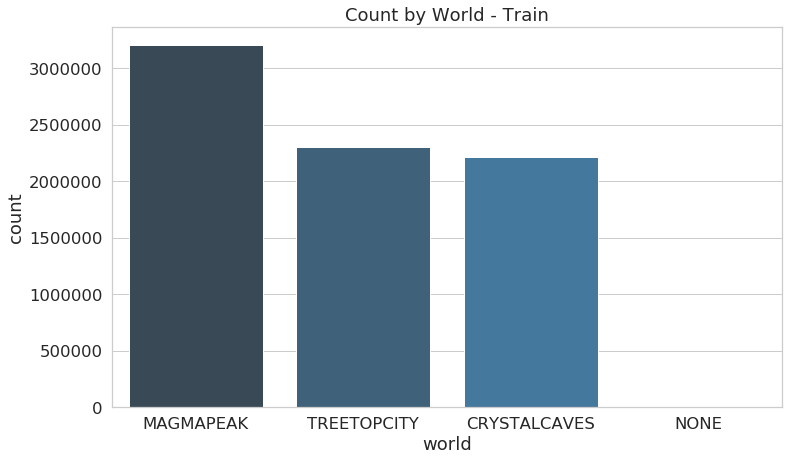

In [31]:
plt.figure(figsize=(12,7))

sns.countplot(x='world',data=train,
             order = train['world'].value_counts().index).set_title('Count by World - Train')

Text(0.5, 1.0, 'Count by World - Test')

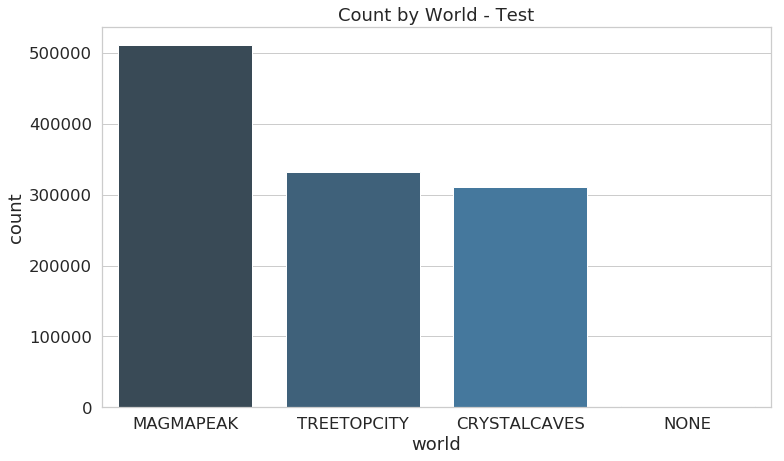

In [32]:
plt.figure(figsize=(12,7))

sns.countplot(x='world',data=test,
             order = test['world'].value_counts().index).set_title('Count by World - Test')

Magma peak seems to be having the highest count in both the train and test sets - not sure why?

Text(0.5, 1.0, 'Count by Title - Train')

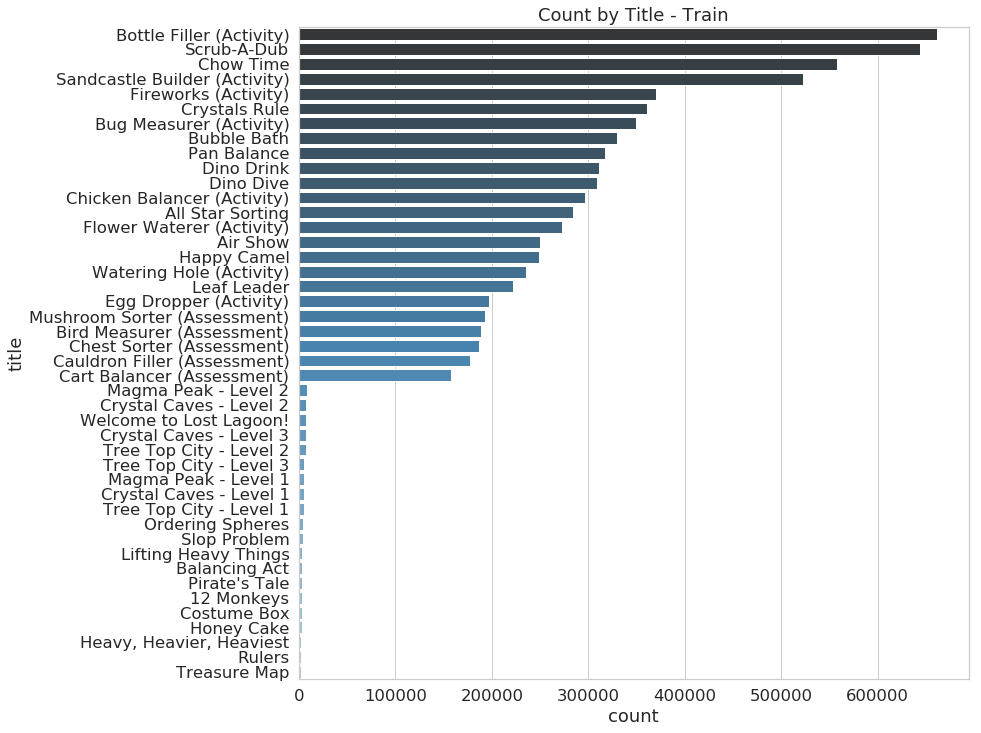

In [33]:
plt.figure(figsize=(12,12))

sns.countplot(y='title',data=train,palette = 'Blues_d',
             order = train['title'].value_counts().index).set_title('Count by Title - Train')

Text(0.5, 1.0, 'Count by Title - Test')

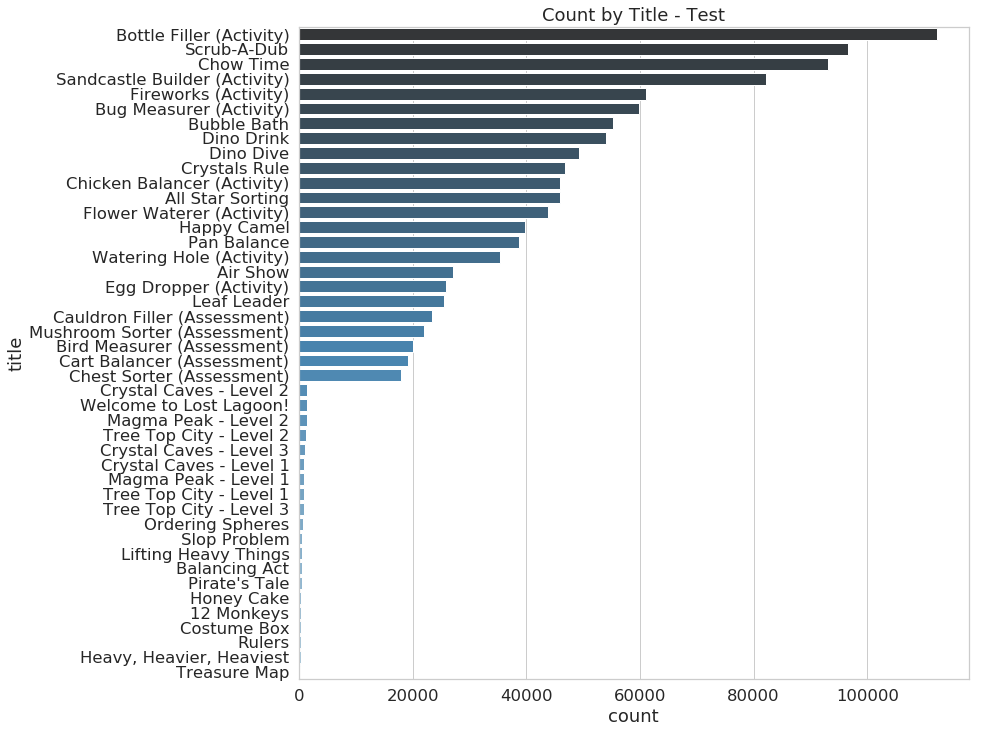

In [34]:
plt.figure(figsize=(12,12))

sns.countplot(y='title',data=test,palette = 'Blues_d',
             order = test['title'].value_counts().index).set_title('Count by Title - Test')

There seems to be a lot of titles. Let's plan later on how to one-hot encode these values for our model. Also for some reason, Bottle Filler and Scrub-A-Dub seems to be the most frequent title in train and test

Text(0.5, 1.0, 'Count by Assessment - Train labels')

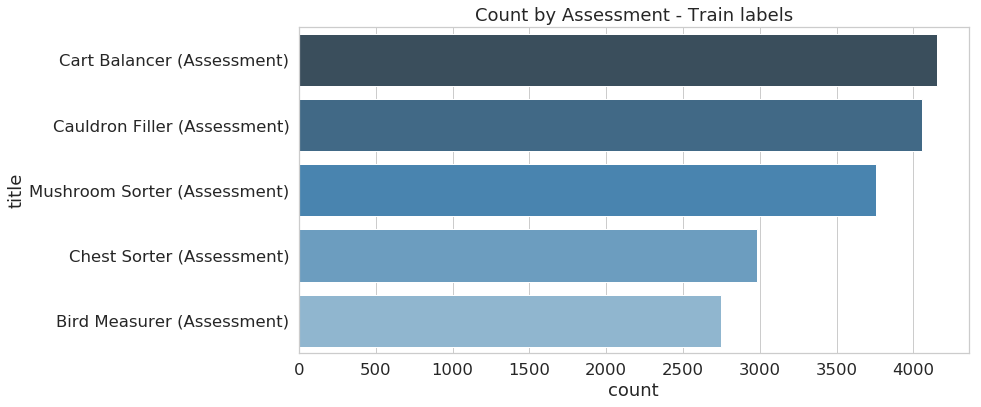

In [35]:
plt.figure(figsize=(12,6))

sns.countplot(y='title',data=train_labels,palette = 'Blues_d',
             order = train_labels['title'].value_counts().index).set_title('Count by Assessment - Train labels')

Text(0.5, 1.0, 'Count by Accuracy Group - Train labels')

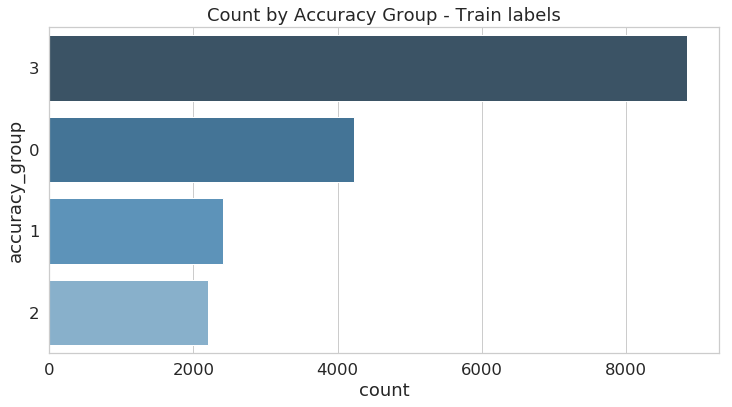

In [36]:
plt.figure(figsize=(12,6))

sns.countplot(y='accuracy_group',data=train_labels,palette = 'Blues_d',
             order = train_labels['accuracy_group'].value_counts().index).set_title('Count by Accuracy Group - Train labels')

Ok so obviously there are lots of incorrect answers before a successful result in an assessment. 

Now, to understand the time stamp field, we'll plot the outcomes. Converting timestamp to datetime

In [37]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


And plotting the day of the week counts

Text(0.5, 1.0, 'Count by Day of the Week - Train')

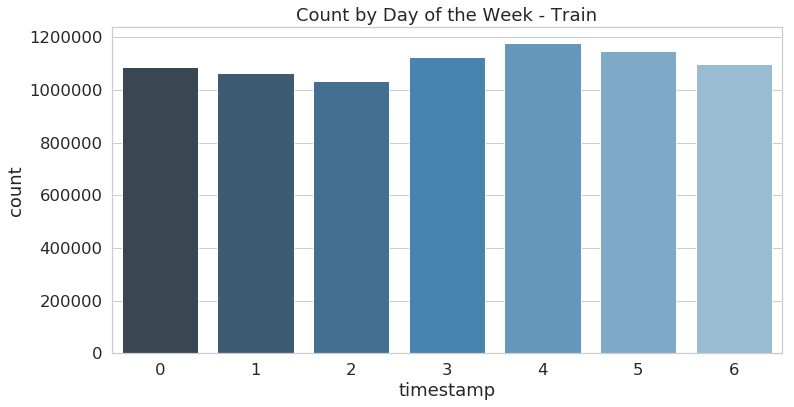

In [38]:
plt.figure(figsize=(12,6))

sns.countplot(x=train['timestamp'].dt.dayofweek,data=train,palette = 'Blues_d').set_title('Count by Day of the Week - Train')

Text(0.5, 1.0, 'Count by Day of the Week - Test')

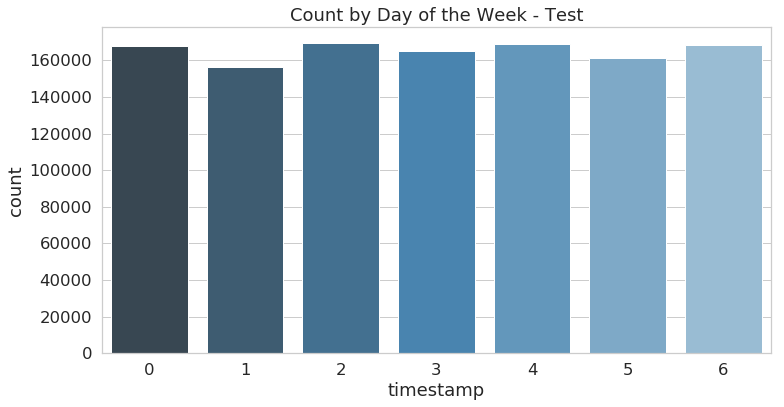

In [39]:
plt.figure(figsize=(12,6))

sns.countplot(x=test['timestamp'].dt.dayofweek,data=test,palette = 'Blues_d').set_title('Count by Day of the Week - Test')

0 denotes Monday, 1 denotes Tuesday and so on...

Train and test looks slightly different. There is a slightly higher count during Fridays and Saturdays in the train data. However in the test, Fridays are much more higher.

Now, to look at hour of day...

Text(0.5, 1.0, 'Count by Hour of the Day - Train')

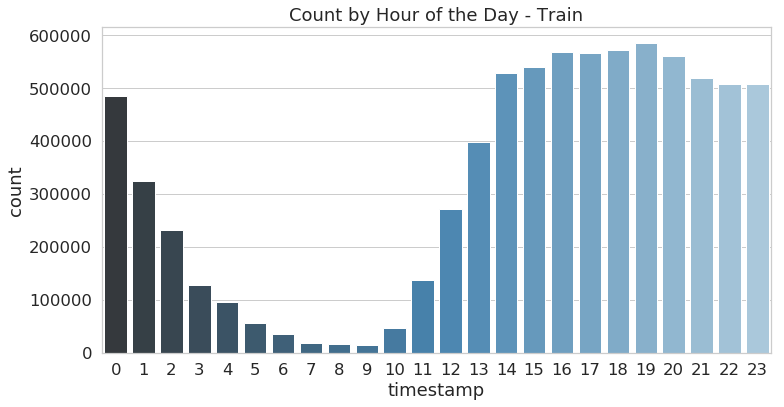

In [40]:
plt.figure(figsize=(12,6))

sns.countplot(x=train['timestamp'].dt.hour,data=train,palette = 'Blues_d').set_title('Count by Hour of the Day - Train')

Text(0.5, 1.0, 'Count by Hour of the Day - Test')

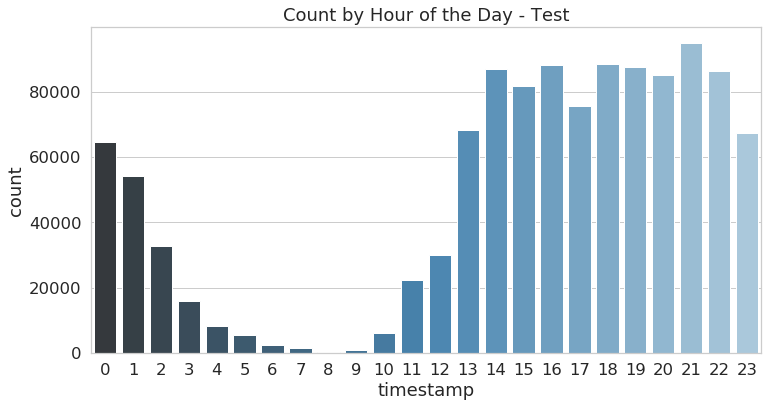

In [41]:
plt.figure(figsize=(12,6))

sns.countplot(x=test['timestamp'].dt.hour,data=test,palette = 'Blues_d').set_title('Count by Hour of the Day - Test')

There is an obvious pattern here, the graph shows lesser usage in the early hours of the day up until noon time.

In [42]:
train=train.sort_values('timestamp')
test=test.sort_values('timestamp')

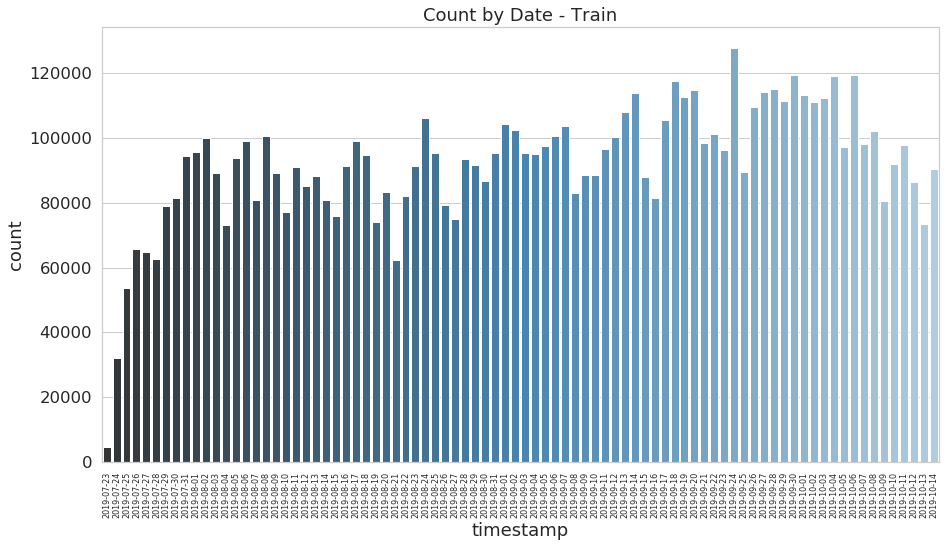

In [43]:
plt.figure(figsize=(15,8))

sns.countplot(x=train['timestamp'].dt.date,data=train,palette = 'Blues_d').set_title('Count by Date - Train')
plt.xticks(rotation=90,fontsize=8)
plt.show()

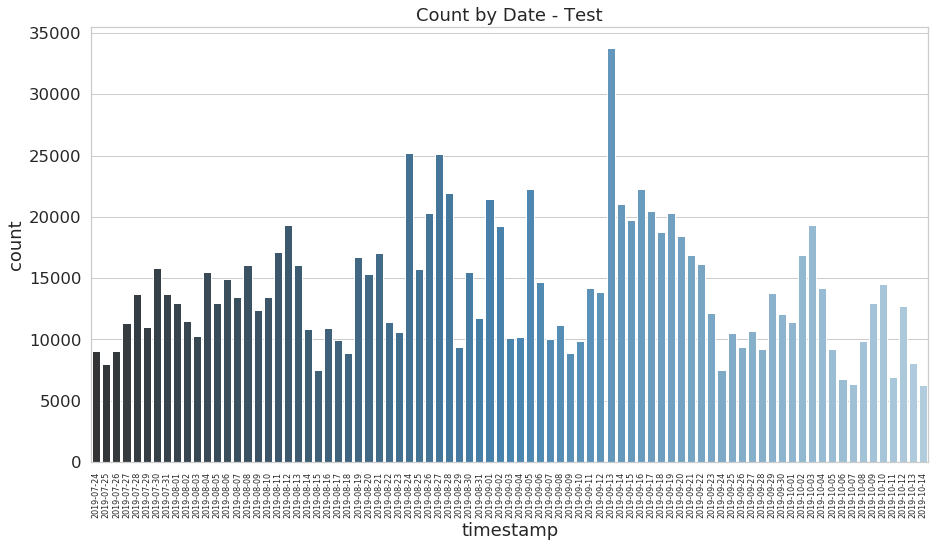

In [44]:
plt.figure(figsize=(15,8))

sns.countplot(x=test['timestamp'].dt.date,data=test,palette = 'Blues_d').set_title('Count by Date - Test')
plt.xticks(rotation=90,fontsize=8)
plt.show()

By plotting count by date range, we don't really see a huge trend in the train. The graph looks pretty standard. However in test there is an obvious peak during August

To prepare the data, we need to join the train and train labels. Also need to format the train and test datasets to feed into the model

We will perform a left join with train and train_labels using installation_id and game_session. Let's drop all other colums in the train labels other than the ones we require i.e. game_session, installation_id and accuracy_group (our target variable). Once joined, let's look into the number of rows to ensure that we performed the join successfully

In [45]:
train.shape

(7734558, 11)

The new train data should have the same number of rows as shown above

In [46]:
train_labels.shape

(17690, 7)

In [47]:
train_labels

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3
...,...,...,...,...,...,...,...
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333252,1
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0


In [48]:
train_new = pd.merge(train, train_labels.filter(['game_session','installation_id','accuracy_group'],axis=1), on=['installation_id','game_session'], how='left')

In [49]:
train = train_new

Ok so we have the same number of rows and added the accuracy group added

# Feature Engineering

Now we will write a function to prepare the train and test datasets. We also need to perform one hot encoding to the dataset. Before we worry about too many dummy variables, let's look into the number of unique values for the data

In [50]:
train.nunique()

event_id               379
game_session        175467
timestamp          7347901
event_data         7457863
installation_id       3614
event_count           3182
event_code              42
game_time           673592
title                   44
type                     4
world                    4
accuracy_group           4
dtype: int64

Title and event code will cause problems for us as they contain several values that need to be converted to dummy variables. Maybe we can group the smaller ones?

In [51]:
grouped_events = train.groupby(['event_code'])['event_code'].count().rename('count').reset_index().sort_values('count', ascending=False)
grouped_events['perc'] = grouped_events['count'] / grouped_events['count'].sum()
grouped_events

,event_code,count,perc
31,4070,1521039,0.196655
25,4030,1046930,0.135357
14,3010,965076,0.124775
17,3110,949880,0.122810
21,4020,861283,0.111355
2,2020,245711,0.031768
4,2030,213416,0.027593
24,4025,194271,0.025117
27,4035,186383,0.024097
15,3020,184810,0.023894


In [52]:
grouped_events_test = test.groupby(['event_code'])['event_code'].count().rename('count').reset_index().sort_values('count', ascending=False)
grouped_events_test['perc'] = grouped_events_test['count'] / grouped_events_test['count'].sum()
grouped_events_test

,event_code,count,perc
31,4070,234260,0.202575
25,4030,160095,0.138441
14,3010,142543,0.123263
17,3110,140268,0.121296
21,4020,126890,0.109727
2,2020,36354,0.031437
4,2030,31885,0.027572
27,4035,30630,0.026487
0,2000,28445,0.024598
15,3020,26782,0.023160


As we can see, there are several smaller events that can be merged together as 'other'. To make things easier let's make the following grouping:

It will also be good to test the same in the test data and check if the main events are the same.

In [53]:
set(grouped_events.head(6).event_code).intersection(grouped_events_test.head(6).event_code)

{2020, 3010, 3110, 4020, 4030, 4070}

Any event_code other than 4070, 4030, 3010, 3110, 4020, 2020 can be grouped together as 'other' or any dummy event_code like '0000'. Let's first convert them into strings.

In [54]:
train['event_code'] = train['event_code'].apply(str)
test['event_code'] = test['event_code'].apply(str)

In [55]:
main_events = grouped_events.head(6).event_code
train[~train.event_code.isin(main_events)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group
0,27253bdc,be15f0d9402d5900,2019-07-23 14:38:25.256000+00:00,"{""event_code"": 2000, ""event_count"": 1}",55ef8814,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN
1,27253bdc,28e017b47f9887c3,2019-07-23 14:38:57.617000+00:00,"{""event_code"": 2000, ""event_count"": 1}",55ef8814,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN
2,77261ab5,905b19967a1974d7,2019-07-23 14:39:36.637000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",55ef8814,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
3,b2dba42b,905b19967a1974d7,2019-07-23 14:39:36.990000+00:00,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""id...",55ef8814,2,3010,403,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
4,1bb5fbdb,905b19967a1974d7,2019-07-23 14:39:43.904000+00:00,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""id...",55ef8814,3,3110,7468,Sandcastle Builder (Activity),Activity,MAGMAPEAK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7734553,b5053438,ca84b8d7c6758795,2019-10-14 21:57:23.341000+00:00,"{""description"":""Look! Each bucket is exactly the right size for the statue! They each hold the same amount of liquid!"",""identifier"":""Dot_EachBucke...",19f0ad61,18,3121,21339,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0
7734554,532a2afb,ca84b8d7c6758795,2019-10-14 21:57:23.348000+00:00,"{""buckets"":[],""target_bucket"":3,""mode"":""selecting"",""prompt"":""holds most"",""round_number"":2,""event_count"":20,""game_time"":21339,""event_code"":2020}",19f0ad61,20,2020,21339,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0
7734555,2dcad279,ca84b8d7c6758795,2019-10-14 21:57:26.742000+00:00,"{""description"":""Okay. Tap the bucket that holds the most amount of liquid."",""identifier"":""Dot_OkayTapBucketMost"",""media_type"":""audio"",""duration"":3...",19f0ad61,21,3110,24740,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0
7734556,28520915,ca84b8d7c6758795,2019-10-14 21:57:26.926000+00:00,"{""misses"":0,""prompt"":""holds most"",""mode"":""selecting"",""round_number"":2,""duration"":3569,""event_count"":23,""game_time"":24908,""event_code"":2030}",19f0ad61,23,2030,24908,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0


Next, we should apply the same logic to the title field

In [56]:
grouped_titles = train.groupby(['title'])['title'].count().rename('count').reset_index().sort_values('count', ascending=False)
grouped_titles['perc'] = grouped_titles['count'] / grouped_titles['count'].sum()
grouped_titles

,title,count,perc
5,Bottle Filler (Activity),661294,0.085499
36,Scrub-A-Dub,643555,0.083205
12,Chow Time,557864,0.072126
35,Sandcastle Builder (Activity),523052,0.067625
21,Fireworks (Activity),370109,0.047851
17,Crystals Rule,360523,0.046612
7,Bug Measurer (Activity),349862,0.045234
6,Bubble Bath,329548,0.042607
32,Pan Balance,317223,0.041014
19,Dino Drink,311314,0.040250


In [57]:
grouped_titles_test = test.groupby(['title'])['title'].count().rename('count').reset_index().sort_values('count', ascending=False)
grouped_titles_test['perc'] = grouped_titles_test['count'] / grouped_titles_test['count'].sum()
grouped_titles_test

,title,count,perc
5,Bottle Filler (Activity),112223,0.097044
36,Scrub-A-Dub,96619,0.083551
12,Chow Time,93142,0.080544
35,Sandcastle Builder (Activity),82132,0.071023
21,Fireworks (Activity),61032,0.052777
7,Bug Measurer (Activity),59886,0.051786
6,Bubble Bath,55264,0.047789
19,Dino Drink,53989,0.046687
18,Dino Dive,49368,0.042691
17,Crystals Rule,46867,0.040528


In [58]:
set(grouped_titles.head(6).title) & set(grouped_titles_test.head(6).title)

{'Bottle Filler (Activity)',
 'Chow Time',
 'Fireworks (Activity)',
 'Sandcastle Builder (Activity)',
 'Scrub-A-Dub'}

In [59]:
main_titles = grouped_titles.head(6).title
train[~train.title.isin(main_titles)]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,accuracy_group
0,27253bdc,be15f0d9402d5900,2019-07-23 14:38:25.256000+00:00,"{""event_code"": 2000, ""event_count"": 1}",55ef8814,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN
1,27253bdc,28e017b47f9887c3,2019-07-23 14:38:57.617000+00:00,"{""event_code"": 2000, ""event_count"": 1}",55ef8814,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN
80,27253bdc,4527643a43dc9747,2019-07-23 15:03:21.049000+00:00,"{""event_code"": 2000, ""event_count"": 1}",76684810,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,NaN
81,27253bdc,052e9e9b310cd436,2019-07-23 15:03:49.391000+00:00,"{""event_code"": 2000, ""event_count"": 1}",76684810,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,NaN
82,27253bdc,01a617d4d06ad51e,2019-07-23 15:04:38.443000+00:00,"{""event_code"": 2000, ""event_count"": 1}",76684810,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7734553,b5053438,ca84b8d7c6758795,2019-10-14 21:57:23.341000+00:00,"{""description"":""Look! Each bucket is exactly the right size for the statue! They each hold the same amount of liquid!"",""identifier"":""Dot_EachBucke...",19f0ad61,18,3121,21339,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0
7734554,532a2afb,ca84b8d7c6758795,2019-10-14 21:57:23.348000+00:00,"{""buckets"":[],""target_bucket"":3,""mode"":""selecting"",""prompt"":""holds most"",""round_number"":2,""event_count"":20,""game_time"":21339,""event_code"":2020}",19f0ad61,20,2020,21339,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0
7734555,2dcad279,ca84b8d7c6758795,2019-10-14 21:57:26.742000+00:00,"{""description"":""Okay. Tap the bucket that holds the most amount of liquid."",""identifier"":""Dot_OkayTapBucketMost"",""media_type"":""audio"",""duration"":3...",19f0ad61,21,3110,24740,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0
7734556,28520915,ca84b8d7c6758795,2019-10-14 21:57:26.926000+00:00,"{""misses"":0,""prompt"":""holds most"",""mode"":""selecting"",""round_number"":2,""duration"":3569,""event_count"":23,""game_time"":24908,""event_code"":2030}",19f0ad61,23,2030,24908,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3.0


In [60]:
def prepare_data(df):
    
    # Adding all the time columns
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    
    # drop any unnecessary columns
    df = df.drop(['timestamp','event_data','game_session','event_id'], axis = 1)
    
    # merge all smaller event codes / titles together
    df.loc[(~df.event_code.isin(main_events),'event_code')]='0000'
    df.loc[(~df.title.isin(main_titles),'title')]='Other'
    
    # convert into dummy variables
    dummies = pd.get_dummies(df[['type','title','world','event_code']])
    
    # drop unnecessary columns
    df = df.drop(['type','title', 'world','event_code'], axis = 1)
    df = pd.concat([df, dummies], axis=1)
    
    return df

In [61]:
train_prep = prepare_data(train)
test_prep = prepare_data(test)

In [62]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
assessed_only         DataFrame             installation_id\<...>\n[4242 rows x 1 columns]
grouped_events        DataFrame        event_code    count  <...>  4080      572  0.000074
grouped_events_test   DataFrame        event_code   count   <...>   4080     109  0.000094
grouped_titles        DataFrame                             <...>ure Map    2255  0.000292
grouped_titles_test   DataFrame                             <...>ure Map     223  0.000193
sample_submission     DataFrame        installation_id  accu<...>\n[1000 rows x 2 columns]
specs                 DataFrame         event_id  \\n0    2b<...>n\n[386 rows x 3 columns]
test                  DataFrame            event_id      gam<...>156414 rows x 15 columns]
test_prep             DataFrame           installation_id  e<...>156414 rows x 23 columns]
train                 DataFrame             event_id      ga<...>734558 rows x 16 columns]


Baseline model - to be continued...